In [2]:
from cppredictor import build_conformal_predictor
from cppredictor import coco_label_from_index
import valToCal
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data.datasets import load_coco_json

import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import json
import numpy as np
from pycocotools.coco import COCO

In [3]:
# Configure Detectron Model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:

import os
import cv2
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = 'cuda'

# Load test image
test_img_path = "/home/datasets/coco/val2017/000000000785.jpg"
test_json_file = "/home/datasets/coco/annotations/instances_val2017.json"
image = cv2.imread(test_img_path)

# Build predictor
predictor = build_conformal_predictor(cfg)
predictor.load_calibration("calib.json")  # Load calibration values


Loaded calibration data


In [18]:
def visualize_conformal_predictions(image, outputs, cfg, scale=1.0):
    """
    이미지와 모델 출력 결과에서 Conformal Region을 시각화하는 함수입니다.
    
    Args:
        image (np.ndarray): 원본 이미지 (BGR 포맷)
        outputs (dict): 모델 예측 결과 (instances 포함)
        cfg: detectron2 설정 객체
        scale (float): visualizer scaling factor (default: 1.0)
    
    Returns:
        output_img (np.ndarray): Conformal Region Box가 그려진 이미지
    """

    # Visualizer를 이용해 인스턴스 예측 시각화
    v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=scale)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # 이미지 복사를 통해 원본 보존
    output_img = out.get_image()[:, :, ::-1].copy()

    # Conformal Region box 그리기
    conformal_regions = outputs["instances"].conformal_region
    for region in conformal_regions:
        pt1 = (int(region["x1_min"]), int(region["y1_min"]))
        pt2 = (int(region["x2_max"]), int(region["y2_max"]))
        cv2.rectangle(output_img, pt1, pt2, (0, 255, 0), 1)

    return output_img

tensor(194.4583, device='cuda:0') tensor(427.5941, device='cuda:0') tensor(351.0880, device='cuda:0') tensor(636.6863, device='cuda:0')
tensor(74.5909, device='cuda:0') tensor(431.6597, device='cuda:0') tensor(230.0389, device='cuda:0') tensor(634.8772, device='cuda:0')
tensor(294.8236, device='cuda:0') tensor(435.2494, device='cuda:0') tensor(461.2806, device='cuda:0') tensor(638.1908, device='cuda:0')
tensor(-35.4664, device='cuda:0') tensor(409.8274, device='cuda:0') tensor(135.6411, device='cuda:0') tensor(623.8560, device='cuda:0')
tensor(134.2952, device='cuda:0') tensor(386.3434, device='cuda:0') tensor(207.7833, device='cuda:0') tensor(504.7910, device='cuda:0')
tensor(280.8953, device='cuda:0') tensor(383.9224, device='cuda:0') tensor(350.0303, device='cuda:0') tensor(535.4207, device='cuda:0')
tensor(84.6567, device='cuda:0') tensor(385.6615, device='cuda:0') tensor(153.4700, device='cuda:0') tensor(542.1534, device='cuda:0')
tensor(-11.6213, device='cuda:0') tensor(392.6094,

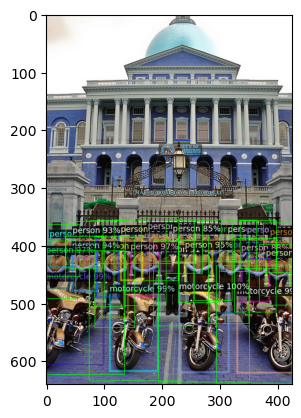

In [ ]:
test_img_path = "/home/datasets/coco/test2017/000000008359.jpg"
test_json_file = "/home/datasets/coco/annotations/instances_val2017.json"

image = image = cv2.imread(test_img_path)

# Predict and conformalize
outputs = predictor(image)
predictor.conformalize(outputs["instances"])
output_img = visualize_conformal_predictions(image, outputs, cfg)
# Visualize the output
plt.imshow(output_img)